<a href="https://colab.research.google.com/github/ZackPashkin/text2cartoon-pytorch-CLIP/blob/main/Text2cartoonNet_Big_Sleep_%2B_CLIP_%2B_one_more_CLIP_%2B_DeepVoice3_%2B_FFmpeg_v230210_latest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
##  Deep Sleep https://github.com/lucidrains/big-sleep
## OpenAI CLIP https://github.com/openai/CLIP
## CLIP unspash https://github.com/haltakov/natural-language-image-search
## DeepVoice3 https://github.com/r9y9/deepvoice3_pytorch


## Restart after running this cell!

You must run this cell and then restart and rerun everything for the PyTorch version to be correct. Otherwise the model will run but not produce any meaningful output.

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install boto3 einops

CUDA version: 10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Process text promt with BigSleep

In [1]:
!rm -rf /content/gan_img

In [2]:
promt__list = ["When he was dreaming, he often saw lions and Africa",
"The old man decided to go fishing",
"Maybe he would be lucky and find a big fish",
"His boat had a mast on it and the boat was quite small"
"Old man meet huge marlin. The fish was really big with long nose",
"He strugled a lot to handle big marlin he has met"]

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


/content/gan_img


promt: 
 a Rembrandt-style painting titled "When he was dreaming, he often saw lions and Africa"
lr:  0.05


image updated at "./101255_a_Rembrandt-style_painting_titled_"When_he_was_dreaming,_he_often_saw_lions_and_Africa".png"



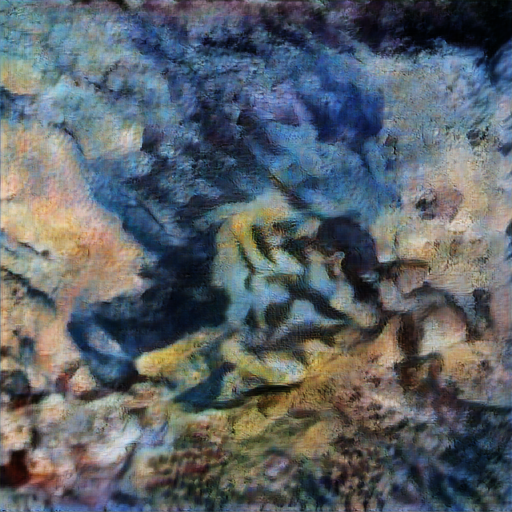

promt: 
 a Rembrandt-style painting titled "When he was dreaming, he often saw lions and Africa"
lr:  0.05


In [ ]:
import sys
sys.path.append("/content/big-sleep-patched/big_sleep")
sys.path.append("/content/big-sleep-patched/")
import os
import re
from glob import glob
import shutil
from tqdm.notebook import tqdm
from IPython.display import Image as Img
from IPython.display import  display
from big_sleep import Imagine

!pip list | grep big-sleep

path_to_save_gan_img = f"{os.getcwd()}/gan_img/"
if not os.path.exists(path_to_save_gan_img):
    os.makedirs(path_to_save_gan_img)
    
%cd /content/gan_img
    
  

EPOCHS = 10
ITERATIONS = 201
SAVE_EVERY = 200

for i,promt in enumerate(promt__list):
  promt = "a Rembrandt-style painting titled " + f'"{promt}"'
  # lr = (i+1)/1000+0.065
  lr = 0.05



  for epoch in tqdm(range(EPOCHS), desc = 'epochs'):
      # lr -= 0.01
      model = Imagine(
        text = promt,
        save_every = SAVE_EVERY,
        lr = lr,
        iterations = ITERATIONS,
        save_progress = False,
        save_date_time = True,
        save_best = True
      )
      print("promt: \n", str(promt))
      print("lr: ", str(lr))
      for i in tqdm(range(ITERATIONS), desc = 'iteration'):
        model.train_step(epoch, i)
      img_name = sorted(glob(f"{path_to_save_gan_img}*.png"))[-1]
      image = Img(img_name)
      display(image)        
          
%cd /content/

# CLIP part make image embeddings

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip
import torch
from pathlib import Path
from PIL import Image
import math
import numpy as np
import pandas as pd


# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)



# Set the path to the photos
# dataset_version = "lite"  # Use "lite" or "full"
photos_path = Path("/content/gan_img") #/ "photos"

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.png"))

# Print some statistics
print(f"Photos found: {len(photos_files)}")



# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()


# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = len(photos_files)

# Path where the feature vectors will be stored
features_path = Path("/content") 

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in range(batches):
  print(f"Processing batch {i+1}/{batches}")

  batch_ids_path = features_path / f"1.csv"
  batch_features_path = features_path / f"1.npy"
  
  # Only do the processing if the batch wasn't processed yet
  # if not batch_features_path.exists():
  #     try:
  # Select the photos for the current batch
  batch_files = photos_files[i*batch_size : (i+1)*batch_size]

  # Compute the features and save to a numpy file
  batch_features = compute_clip_features(batch_files)
  np.save(batch_features_path, batch_features)

  # Save the photo IDs to a CSV file
  # photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
  photo_ids = [photo_file for photo_file in batch_files]
  print(photo_ids)
  photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
  photo_ids_data.to_csv(batch_ids_path, index=False)
      # except:
          # # Catch problems with the processing to make the process more robust
          # print(f'Problem with batch {i}')


# Load the photo IDs
photo_ids = pd.read_csv("/content/1.csv")
photo_ids = list(photo_ids['photo_id'])

# Load the features vectors
photo_features = np.load("/content/1.npy")

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector from the GPU and convert it to a numpy array
  return text_encoded.cpu().numpy()

def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = np.argsort(similarities)[::-1]

  # Return the photo IDs of the best matches
  return [photo_ids[i] for i in best_photo_idx[:results_count]]


def display_photo(photo_id):
  display(Img(photo_id))
  


def search_with_clip(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)
  
  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id) 

Photos found: 12
Processing batch 1/1
[PosixPath("/content/gan_img/0.13'Hunger,_wars,_droughts,_revolutions_..._What_to_do_if_such_a_misfortune_happened_to_your_country,_tribe_or_nation?'.png"), PosixPath("/content/gan_img/0.065'According_to_the_author,_chamomile_is_the_most_dear_flower_of_our_land.the_most_dear_flower_of_our_land'.png"), PosixPath("/content/gan_img/0.195'Hunger,_wars,_droughts,_revolutions_..._What_to_do_if_such_a_misfortune_happened_to_your_country,_tribe_or_nation?'.png"), PosixPath("/content/gan_img/0.13'According_to_the_author,_chamomile_is_the_most_dear_flower_of_our_land'.png"), PosixPath("/content/gan_img/0.195'According_to_the_author,_chamomile_is_the_most_dear_flower_of_our_land'.png"), PosixPath("/content/gan_img/0.065'According_to_the_author,_chamomile_is_the_most_dear_flower_of_our_land'.png"), PosixPath("/content/gan_img/0.13to_the_author,_chamomile_is_the_most_dear_flower_of_our_land.the_most_dear_flower_of_our_land'.png"), PosixPath("/content/gan_img/0.

## process with CLIP

In [ ]:
# rank images from gan
rus_promt = "Little prince"
search_query = " ".join(promt_list)
print(search_query)
search_with_clip(search_query, photo_features, photo_ids, 1)

# Draw text on result images 

In [ ]:
%cd /content/
!mkdir png_with_text

In [ ]:
from PIL import Image,ImageDraw,ImageFont
import glob
# draw text on images
%cd /content/png_with_text

def text_from_im_path(im_path):
  text_from_im_path = im_path.split("/")[-1].split('.')[0]
  text_from_im_path = text_from_im_path.replace('_', " ")
  return text_from_im_path

def draw_text_on_image_save(im_path):
  im = Image.open(im_path)
  TEXT = text_from_im_path(im_path)
  font_type = ImageFont.load_default()
  draw = ImageDraw.Draw(im)
  draw.text(xy=(130, 460), text= TEXT, fill =(255,255,255), font = font_type)
  return im



imgs = glob.glob("/content/gan_img1/*.png")

for im_path in sorted(imgs):
  text_from_im_path = text_from_im_path(im_path)
  res = draw_text_on_image_save(im_path)
  res.save(f'{text_from_im_path}.png')

%cd /content/
print("Done")

/content/png_with_text
/content
Done


# Vocalize text

In [ ]:
# not sure it's needed
# !pip install tensorflow==1.4

## Setup

### Install dependencies

In [ ]:
import os
from os.path import exists, join, expanduser

# Clone
name = "deepvoice3_pytorch"
if not exists(name):
  ! git clone https://github.com/r9y9/$name

Cloning into 'deepvoice3_pytorch'...
remote: Enumerating objects: 1151, done.
remote: Total 1151 (delta 0), reused 0 (delta 0), pack-reused 1151
Receiving objects: 100% (1151/1151), 6.94 MiB | 8.98 MiB/s, done.
Resolving deltas: 100% (643/643), done.


In [ ]:
# Change working directory to the project dir 
# os.chdir(join(expanduser("~"), name))
%cd /content/deepvoice3_pytorch
!git checkout 7a10ac6763eda92595e257543494b6a95f64229b --quiet

# Install dependencices
!pip install -q -e '.[bin]'

/content/deepvoice3_pytorch
     |████████████████████████████████| 245kB 11.8MB/s 
     |████████████████████████████████| 143kB 26.4MB/s 
     |████████████████████████████████| 317kB 20.9MB/s 
     |████████████████████████████████| 1.7MB 27.7MB/s 
     |████████████████████████████████| 419kB 56.6MB/s 
     |████████████████████████████████| 368kB 45.1MB/s 


In [ ]:
%pylab inline
! pip install -q librosa nltk

import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

Populating the interactive namespace from numpy and matplotlib
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


### Download a pre-trained model

In [ ]:
preset = "20180505_deepvoice3_ljspeech.json"
checkpoint_path = "20180505_deepvoice3_checkpoint_step000640000.pth"

In [ ]:
if not exists(preset):
  !curl -O -L "https://www.dropbox.com/s/0ck82unm0bo0rxd/20180505_deepvoice3_ljspeech.json"
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/5ucl9remrwy5oeg/20180505_deepvoice3_checkpoint_step000640000.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1795  100  1795    0     0   1413      0  0:00:01  0:00:01 --:--:--  6105
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   990    0   990    0     0    507      0 --:--:--  0:00:01 --:--:-- 17068
100  151M  100  151M    0     0  14.8M      0  0:00:10  0:00:10 --:--:-- 23.4M


## Synthesis

### Setup hyper parameters

In [ ]:
import hparams
import json

    
# Load parameters from preset
with open(preset) as f:
  hparams.hparams.parse_json(f.read())
  
# Inject frontend text processor
import synthesis
import train
from deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.hparams.sample_rate
hop_length = hparams.hparams.hop_size

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

### Define utility functions

In [ ]:
def tts(model, text, p=0, speaker_id=None, fast=True, figures=True):
  from synthesis import tts as _tts
  
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  if figures:
      visualize(alignment, spectrogram)
  IPython.display.display(Audio(waveform, rate=fs))
  
def visualize(alignment, spectrogram):
  label_fontsize = 16
  figure(figsize=(16,16))

  subplot(2,1,1)
  imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  xlabel("Decoder timestamp", fontsize=label_fontsize)
  ylabel("Encoder timestamp", fontsize=label_fontsize)
  colorbar()

  subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  xlabel("Time", fontsize=label_fontsize)
  ylabel("Hz", fontsize=label_fontsize)
  tight_layout()
  colorbar()

### Load the model checkpoint

In [ ]:
from train import build_model
from train import restore_parts, load_checkpoint

model = build_model()

model = load_checkpoint(checkpoint_path, model, None, True)

Load checkpoint from: 20180505_deepvoice3_checkpoint_step000640000.pth


### Generate speech

In [ ]:
import glob
imgs = glob.glob("/content/png_with_text/*.png")
promt__dict = {}
for im_path in sorted(imgs):
  text_from_im_path = im_path.split("/")[-1].split('.')[0]
  text_from_im_path = text_from_im_path.replace('_', " ")
  promt__dict[im_path] =  text_from_im_path
  

for i in promt__dict.values():
  print(i)

A flower was standing near little prince
It was very astonishing  blue planet
Little prince and his flower flew to another blue planet
Little prince built another green rocket
Little prince dreams about visiting other planets
Look at the Space - it's so cold out there
So many planets and stars and galaxies in the space


In [ ]:
import audio
from scipy.io import wavfile

def tts1(model, text, p=0, speaker_id=None, fast=True, figures=True,path=None):
  from synthesis import tts as _tts
  
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
 
  
  if figures:
      visualize(alignment, spectrogram)

  IPython.display.display(Audio(waveform, rate=fs))
  audio.save_wav(wav=waveform, path=f"{path}.wav")
  
def visualize(alignment, spectrogram):
  label_fontsize = 16
  figure(figsize=(16,16))

  subplot(2,1,1)
  imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  xlabel("Decoder timestamp", fontsize=label_fontsize)
  ylabel("Encoder timestamp", fontsize=label_fontsize)
  colorbar()

  subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  xlabel("Time", fontsize=label_fontsize)
  ylabel("Hz", fontsize=label_fontsize)
  tight_layout()
  colorbar()

In [ ]:
%cd /content/
!mkdir WAVS
# !rm -rf /content/deepvoice3_pytorch/WAVS

/content


In [ ]:
%cd WAVS

for path in promt__dict.values():
  text = path

  tts1(model, text, fast=False, figures=False,path=path)

%cd /content/

/content/WAVS


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/content


For details, please visit https://github.com/r9y9/deepvoice3_pytorch

# Stitch sound and images to mp4

In [ ]:
!pip install ffmpeg-python
import ffmpeg

In [ ]:
!pwd
%cd /content/
!mkdir CARTOON
# !rm -rf /content/CARTOON

/content/CARTOON


In [ ]:
import ffmpeg
%cd /content/CARTOON

for im_path in promt__dict.values():
  input_still = ffmpeg.input(os.path.join('/content/png_with_text/',f"{im_path}.png"))
  input_audio = ffmpeg.input(os.path.join('/content/WAVS/',f"{im_path}.wav"))
  try:
    (
        ffmpeg
        .concat(input_still, input_audio, v=1, a=1)
        .output(f"{im_path}.mp4")
        .run(capture_stdout=True, capture_stderr=True, overwrite_output=True)
    )
  except ffmpeg.Error as e:
              print('stdout:', e.stdout.decode('utf8'))
              print('stderr:', e.stderr.decode('utf8'))
              raise e
%cd /content/

/content/CARTOON
/content


In [ ]:
# create vidlist.txt
# ! NOTE: take care of sortinhg frames in the right order
d = {}
with open('vidlist.txt', 'w') as f:
  for path in glob.glob("/content/CARTOON/*.mp4"):
    print(path)
    d['file'] = str(path)
  f.write(d)


/content/CARTOON/Look at the Space - it's so cold out there.mp4
/content/CARTOON/So many planets and stars and galaxies in the space.mp4
/content/CARTOON/Little prince dreams about visiting other planets.mp4
/content/CARTOON/Little prince and his flower flew to another blue planet.mp4
/content/CARTOON/Little prince built another green rocket.mp4
/content/CARTOON/It was very astonishing  blue planet.mp4
/content/CARTOON/A flower was standing near little prince.mp4


In [ ]:
# concat all mp4 frames
!ffmpeg -f concat -safe 0 -i vidlist.txt -c copy cartoon.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
# Download result
from google.colab import files

files.download('cartoon.mp4')

In [ ]:
# Done
